# Causes of changes

Examination of the reason for changes in climate projections.

In [31]:
%load_ext nb_black

The nb_black extension is already loaded. To reload it, use:
  %reload_ext nb_black


<IPython.core.display.Javascript object>

In [32]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


<IPython.core.display.Javascript object>

In [33]:
import os.path
import string

import matplotlib.pyplot as plt
import pandas as pd
import scmdata
import scmdata.database
import seaborn as sns
import tqdm.autonotebook as tqdman

import utils
import utils.plotting

<IPython.core.display.Javascript object>

In [34]:
plt.rcParams["pdf.use14corefonts"] = True
plt.rcParams["text.usetex"] = False
plt.rcParams["axes.unicode_minus"] = False
plt.rcParams["font.size"] = 10
plt.rcParams["axes.xmargin"] = 0
# plt.rcParams["figure.figsize"] = [12, 8]

<IPython.core.display.Javascript object>

In [35]:
ID_1 = "AR6 calibration SR1.5 processing MAGICCv7.5.3"
HARMONISE_PERCENTILES_1 = False
RENAME_VARIABLES_1 = False

# ID_1 = "SR1.5 calibration SR1.5 processing MAGICC6"
# HARMONISE_PERCENTILES_1 = True
# RENAME_VARIABLES_1 = True

# ID_2 = "RCMIP Phase 2 calibration SR1.5 processing MAGICCv7.5.3"
# HARMONISE_PERCENTILES_2 = False
# RENAME_VARIABLES_2 = False

# ID_1 = "RCMIP Phase 2 calibration SR1.5 processing MAGICCv7.5.3"
# HARMONISE_PERCENTILES_1 = False
# RENAME_VARIABLES_1 = False

ID_2 = "SR1.5 calibration SR1.5 processing MAGICC6"
HARMONISE_PERCENTILES_2 = True
RENAME_VARIABLES_2 = True

# # # # ID_1 = "AR6 calibration SR1.5 processing FaIRv1.6.2"
# # # # HARMONISE_PERCENTILES_1 = False
# # # # RENAME_VARIABLES_1 = False

ID_2 = "AR6 calibration SR1.5 processing FaIRv1.6.2"
HARMONISE_PERCENTILES_2 = False
RENAME_VARIABLES_2 = False

# # # ID_2 = "SR1.5 calibration SR1.5 processing FaIR1.3"
# # # HARMONISE_PERCENTILES_2 = True
# # # RENAME_VARIABLES_2 = True

<IPython.core.display.Javascript object>

In [36]:
variables_percentiles = (
    ("Surface Temperature (GSAT)", ["50.0", "67.0", "90.0"]),
    #     ("Raw Surface Temperature (GSAT)|Non-CO2", ["50.0", "mean"]),
    ("Atmospheric Concentrations|CO2", ["50.0"]),
    ("Atmospheric Concentrations|CH4", ["50.0"]),
    ("*Forcing|Basket|Anthropogenic", ["50.0"]),
    ("*Forcing", ["50.0"]),
    ("*Forcing|CO2", ["50.0"]),
    ("*Forcing|CH4", ["50.0"]),
    ("*Forcing|Aerosols", ["50.0"]),
    #     ("*Forcing|*Ozone", ["50.0"]),
    #     ("*Forcing|Montreal*", ["50.0"]),
)

<IPython.core.display.Javascript object>

In [37]:
sr15_db = scmdata.database.ScmDatabase(
    os.path.join(utils.DATA_DIR, "processed", os.path.join("sr15-output")),
    levels=("variable", "percentile"),
)
sr15_emissions = sr15_db.load(variable="Emissions|CO2")
sr15_emissions

Loading files:   0%|          | 0/1 [00:00<?, ?it/s]

<scmdata.ScmRun (timeseries: 414, timepoints: 33)>
Time:
	Start: 2000-01-01T00:00:00
	End: 2100-01-01T00:00:00
Meta:
	    Kyoto-GHG|2010 (SAR) SR1.5 Table 2.4 aim_over_sampling   climate_model  \
	0                exclude           False             False  not_applicable   
	1                exclude           False             False  not_applicable   
	2                exclude           False             False  not_applicable   
	3                exclude           False             False  not_applicable   
	4                exclude           False             False  not_applicable   
	..                   ...             ...               ...             ...   
	409             in range           False              True  not_applicable   
	410             in range           False              True  not_applicable   
	411             in range           False              True  not_applicable   
	412             in range           False              True  not_applicable   
	413          

<IPython.core.display.Javascript object>

In [38]:
def _rename(inp, inverse, mapping):
    out = inp

    for old, new in mapping:
        if not inverse:
            out = out.replace(old, new)
        else:
            out = out.replace(new, old)

    return out


def harmonise_p(p, inverse=False, replacements=(("67.0", "66.0"),)):
    return _rename(p, inverse, replacements)


def rename_v(
    v,
    inverse=False,
    replacements=(
        ("Forcing", "Effective Radiative Forcing"),
        (
            "Tropospheric Ozone",
            "Ozone",
        ),  # not the same but near enough for quick comparisons
    ),
):
    return _rename(v, inverse, replacements)


def load_data(
    id_in,
    variables_percentiles,
    harmonise_percentiles=False,
    rename_variables=False,
):
    assert id_in in utils.plotting.ID_MAP
    if id_in == "AR6 calibration SR1.5 processing MAGICCv7.5.3":
        db_subdir = os.path.join("ar6-output", "MAGICC", utils.AR6_OUTPUT_SR15_RAW_ID)
        climate_model = "MAGICCv7.5.3"
        load_anthropogenic = True
    elif id_in == "RCMIP Phase 2 calibration SR1.5 processing MAGICCv7.5.3":
        db_subdir = os.path.join(
            "ar6-output", "MAGICC", utils.AR6_OUTPUT_SR15_RAW_RCMIP_PHASE_2_CONFIG_ID
        )
        climate_model = "MAGICCv7.5.3"
        load_anthropogenic = True
    elif id_in == "AR6 calibration SR1.5 processing FaIRv1.6.2":
        db_subdir = os.path.join("ar6-output", "fair", "sr15-processing")
        climate_model = "FaIRv1.6.2"
        load_anthropogenic = True
    elif id_in == "SR1.5 calibration SR1.5 processing MAGICC6":
        db_subdir = os.path.join("sr15-output")
        climate_model = "MAGICC6"
        load_anthropogenic = "same as total"

        if harmonise_percentiles:
            variables_percentiles = [
                (v, [harmonise_p(ps) for ps in p]) for v, p in variables_percentiles
            ]
    elif id_in == "SR1.5 calibration SR1.5 processing FaIR1.3":
        db_subdir = os.path.join("sr15-output")
        climate_model = "FaIR1.3"
        load_anthropogenic = "same as total"

        if harmonise_percentiles:
            variables_percentiles = [
                (v, [harmonise_p(ps) for ps in p]) for v, p in variables_percentiles
            ]

    else:
        raise NotImplementedError(id_in)

    db = scmdata.database.ScmDatabase(
        os.path.join(
            utils.DATA_DIR,
            "processed",
            db_subdir,
        ),
        levels=("variable", "percentile"),
    )
    #     display(sorted(db.available_data()["variable"].unique()))
    if load_anthropogenic is not True:
        variables_percentiles = [
            (v, p) for v, p in variables_percentiles if "Anthropogenic" not in v
        ]

    print(variables_percentiles)
    raw_dat = scmdata.run_append(
        [
            utils.load_with_mod_scen(
                db, variable=v, percentile=p, harmonise_model_scenario_names=True
            )
            for v, p in variables_percentiles
        ]
    )

    if harmonise_percentiles:
        raw_dat["percentile"] = raw_dat["percentile"].apply(harmonise_p, inverse=True)

    if rename_variables:
        raw_dat["variable"] = raw_dat["variable"].apply(rename_v, inverse=False)

    if load_anthropogenic == "same as total":
        tmp = raw_dat.filter(variable="Effective Radiative Forcing").copy()
        tmp["variable"] = "Effective Radiative Forcing|Basket|Anthropogenic"
        raw_dat = raw_dat.append(tmp)

    out = raw_dat.filter(climate_model=climate_model)
    out["id"] = id_in

    out = utils.copy_sr15_table_24_metadata_throughout(
        out.append(sr15_emissions)
    ).filter(variable="Emissions*", keep=False)

    return out

<IPython.core.display.Javascript object>

In [39]:
dat_1 = load_data(
    ID_1,
    variables_percentiles=variables_percentiles,
    harmonise_percentiles=HARMONISE_PERCENTILES_1,
    rename_variables=RENAME_VARIABLES_1,
)
dat_1

(('Surface Temperature (GSAT)', ['50.0', '67.0', '90.0']), ('Atmospheric Concentrations|CO2', ['50.0']), ('Atmospheric Concentrations|CH4', ['50.0']), ('*Forcing|Basket|Anthropogenic', ['50.0']), ('*Forcing', ['50.0']), ('*Forcing|CO2', ['50.0']), ('*Forcing|CH4', ['50.0']), ('*Forcing|Aerosols', ['50.0']))


Loading files:   0%|          | 0/3 [00:00<?, ?it/s]

Loading files:   0%|          | 0/1 [00:00<?, ?it/s]

Loading files:   0%|          | 0/1 [00:00<?, ?it/s]

Loading files:   0%|          | 0/1 [00:00<?, ?it/s]

Loading files:   0%|          | 0/1 [00:00<?, ?it/s]

Loading files:   0%|          | 0/1 [00:00<?, ?it/s]

Loading files:   0%|          | 0/1 [00:00<?, ?it/s]

Loading files:   0%|          | 0/1 [00:00<?, ?it/s]

<scmdata.ScmRun (timeseries: 4110, timepoints: 106)>
Time:
	Start: 1995-01-01T00:00:00
	End: 2100-01-01T00:00:00
Meta:
	     Kyoto-GHG|2010 (SAR) SR1.5 Table 2.4 aim_over_sampling climate_model  \
	0                in range            True             False  MAGICCv7.5.3   
	1                in range            True             False  MAGICCv7.5.3   
	2                in range            True             False  MAGICCv7.5.3   
	3                in range            True             False  MAGICCv7.5.3   
	4                in range            True             False  MAGICCv7.5.3   
	...                   ...             ...               ...           ...   
	4518             in range            True             False  MAGICCv7.5.3   
	4519             in range            True             False  MAGICCv7.5.3   
	4520             in range            True             False  MAGICCv7.5.3   
	4521             in range            True             False  MAGICCv7.5.3   
	4522             in ra

<IPython.core.display.Javascript object>

In [40]:
dat_2 = load_data(
    ID_2,
    variables_percentiles=variables_percentiles,
    harmonise_percentiles=HARMONISE_PERCENTILES_2,
    rename_variables=RENAME_VARIABLES_2,
)
dat_2

(('Surface Temperature (GSAT)', ['50.0', '67.0', '90.0']), ('Atmospheric Concentrations|CO2', ['50.0']), ('Atmospheric Concentrations|CH4', ['50.0']), ('*Forcing|Basket|Anthropogenic', ['50.0']), ('*Forcing', ['50.0']), ('*Forcing|CO2', ['50.0']), ('*Forcing|CH4', ['50.0']), ('*Forcing|Aerosols', ['50.0']))


Loading files:   0%|          | 0/3 [00:00<?, ?it/s]

Loading files:   0%|          | 0/1 [00:00<?, ?it/s]

Loading files:   0%|          | 0/1 [00:00<?, ?it/s]

Loading files:   0%|          | 0/1 [00:00<?, ?it/s]

Loading files:   0%|          | 0/1 [00:00<?, ?it/s]

Loading files:   0%|          | 0/1 [00:00<?, ?it/s]

Loading files:   0%|          | 0/1 [00:00<?, ?it/s]

Loading files:   0%|          | 0/1 [00:00<?, ?it/s]

<scmdata.ScmRun (timeseries: 4110, timepoints: 106)>
Time:
	Start: 1995-01-01T00:00:00
	End: 2100-01-01T00:00:00
Meta:
	     Kyoto-GHG|2010 (SAR) SR1.5 Table 2.4 aim_over_sampling climate_model  \
	0                in range            True             False    FaIRv1.6.2   
	1                in range            True             False    FaIRv1.6.2   
	2                in range            True             False    FaIRv1.6.2   
	3                in range            True             False    FaIRv1.6.2   
	4                in range            True             False    FaIRv1.6.2   
	...                   ...             ...               ...           ...   
	4518             in range            True             False    FaIRv1.6.2   
	4519             in range            True             False    FaIRv1.6.2   
	4520             in range            True             False    FaIRv1.6.2   
	4521             in range            True             False    FaIRv1.6.2   
	4522             in ra

<IPython.core.display.Javascript object>

In [41]:
display(dat_1.head())
dat_1.get_unique_meta("variable")

time                                                                                                                                                                                                                                                         1995-01-01  \
Kyoto-GHG|2010 (SAR) SR1.5 Table 2.4 aim_over_sampling climate_model id                                            methodology model       model_scenario                     percentile region scenario               unit variable                                      
in range             True            False             MAGICCv7.5.3  AR6 calibration SR1.5 processing MAGICCv7.5.3 SR1.5       AIM/CGE 2.0 AIM/CGE 2.0-ADVANCE_2020_1.5C-2100 50.0       World  ADVANCE_2020_1.5C-2100 K    Surface Temperature (GSAT)         0.540477   
                                                                                                                                                                              67.0       World  ADVANCE_2020_1.5C-2100 K    Surface Temperature (GSAT)         0.565010   
                                                                                                                                                                              90.0       World  ADVANCE_2020_1.5C-2100 K    Surface Temperature (GSAT)         0.621410   
                                                                                                                                                                              50.0       World  ADVANCE_2020_1.5C-2100 ppm  Atmospheric Concentrations|CO2   360.239000   
                                                                                                                                                                                                                       ppb  Atmospheric Concentrations|CH4  1755.230000   

time                                                                                                                                                                                                                                                         1996-01-01  \
Kyoto-GHG|2010 (SAR) SR1.5 Table 2.4 aim_over_sampling climate_model id                                            methodology model       model_scenario                     percentile region scenario               unit variable                                      
in range             True            False             MAGICCv7.5.3  AR6 calibration SR1.5 processing MAGICCv7.5.3 SR1.5       AIM/CGE 2.0 AIM/CGE 2.0-ADVANCE_2020_1.5C-2100 50.0       World  ADVANCE_2020_1.5C-2100 K    Surface Temperature (GSAT)         0.605818   
                                                                                                                                                                              67.0       World  ADVANCE_2020_1.5C-2100 K    Surface Temperature (GSAT)         0.630074   
                                                                                                                                                                              90.0       World  ADVANCE_2020_1.5C-2100 K    Surface Temperature (GSAT)         0.681489   
                                                                                                                                                                              50.0       World  ADVANCE_2020_1.5C-2100 ppm  Atmospheric Concentrations|CO2   362.005000   
                                                                                                                                                                                                                       ppb  Atmospheric Concentrations|CH4  1757.190000   

time                                                                                                                                                                                                                                                         1997-01

['Surface Temperature (GSAT)',
 'Atmospheric Concentrations|CO2',
 'Atmospheric Concentrations|CH4',
 'Effective Radiative Forcing|Basket|Anthropogenic',
 'Effective Radiative Forcing',
 'Effective Radiative Forcing|CO2',
 'Effective Radiative Forcing|CH4',
 'Effective Radiative Forcing|Aerosols']

<IPython.core.display.Javascript object>

In [42]:
display(dat_2.head())
dat_2.get_unique_meta("variable")

time                                                                                                                                                                                                                                                       1995-01-01  \
Kyoto-GHG|2010 (SAR) SR1.5 Table 2.4 aim_over_sampling climate_model id                                          methodology model       model_scenario                     percentile region scenario               unit variable                                      
in range             True            False             FaIRv1.6.2    AR6 calibration SR1.5 processing FaIRv1.6.2 SR1.5       AIM/CGE 2.0 AIM/CGE 2.0-ADVANCE_2020_1.5C-2100 50.0       World  ADVANCE_2020_1.5C-2100 K    Surface Temperature (GSAT)         0.476595   
                                                                                                                                                                            67.0       World  ADVANCE_2020_1.5C-2100 K    Surface Temperature (GSAT)         0.516698   
                                                                                                                                                                            90.0       World  ADVANCE_2020_1.5C-2100 K    Surface Temperature (GSAT)         0.585800   
                                                                                                                                                                            50.0       World  ADVANCE_2020_1.5C-2100 ppm  Atmospheric Concentrations|CO2   360.127932   
                                                                                                                                                                                                                     ppb  Atmospheric Concentrations|CH4  1755.229625   

time                                                                                                                                                                                                                                                       1996-01-01  \
Kyoto-GHG|2010 (SAR) SR1.5 Table 2.4 aim_over_sampling climate_model id                                          methodology model       model_scenario                     percentile region scenario               unit variable                                      
in range             True            False             FaIRv1.6.2    AR6 calibration SR1.5 processing FaIRv1.6.2 SR1.5       AIM/CGE 2.0 AIM/CGE 2.0-ADVANCE_2020_1.5C-2100 50.0       World  ADVANCE_2020_1.5C-2100 K    Surface Temperature (GSAT)         0.548915   
                                                                                                                                                                            67.0       World  ADVANCE_2020_1.5C-2100 K    Surface Temperature (GSAT)         0.589130   
                                                                                                                                                                            90.0       World  ADVANCE_2020_1.5C-2100 K    Surface Temperature (GSAT)         0.655205   
                                                                                                                                                                            50.0       World  ADVANCE_2020_1.5C-2100 ppm  Atmospheric Concentrations|CO2   361.717640   
                                                                                                                                                                                                                     ppb  Atmospheric Concentrations|CH4  1757.190593   

time                                                                                                                                                                                                                                                       1997-01-01  \
Kyoto-GHG|2010 (SAR) SR

['Surface Temperature (GSAT)',
 'Atmospheric Concentrations|CO2',
 'Atmospheric Concentrations|CH4',
 'Effective Radiative Forcing|Basket|Anthropogenic',
 'Effective Radiative Forcing',
 'Effective Radiative Forcing|CO2',
 'Effective Radiative Forcing|CH4',
 'Effective Radiative Forcing|Aerosols']

<IPython.core.display.Javascript object>

In [43]:
vsum = [
    #  'Effective Radiative Forcing',
    "Effective Radiative Forcing|CO2",
    "Effective Radiative Forcing|CH4",
    "Effective Radiative Forcing|Aerosols",
    #  'Effective Radiative Forcing|Basket|Anthropogenic'
]


def calc_vsum(inp, out_name):
    tmp = inp.filter(variable=vsum).process_over(
        "variable",
        "sum",
        #     op_cols={"variable": },
    )
    tmp["variable"] = out_name

    return scmdata.ScmRun(tmp)


dat_1 = dat_1.append(
    calc_vsum(dat_1, "Effective Radiative Forcing|CO2, CH4 and aerosols")
)
dat_2 = dat_2.append(
    calc_vsum(dat_2, "Effective Radiative Forcing|CO2, CH4 and aerosols")
)


def calc_nonco2(inp):
    out = inp.filter(
        variable="Effective Radiative Forcing|Basket|Anthropogenic"
    ).subtract(
        inp.filter(variable="Effective Radiative Forcing|CO2"),
        op_cols={
            "variable": "Effective Radiative Forcing|Basket|Non-CO2 Anthropogenic"
        },
    )

    return out


dat_1 = dat_1.append(calc_nonco2(dat_1))
dat_2 = dat_2.append(calc_nonco2(dat_2))

dat_2

<scmdata.ScmRun (timeseries: 4932, timepoints: 106)>
Time:
	Start: 1995-01-01T00:00:00
	End: 2100-01-01T00:00:00
Meta:
	     Kyoto-GHG|2010 (SAR) SR1.5 Table 2.4 aim_over_sampling climate_model  \
	0                in range            True             False    FaIRv1.6.2   
	1                in range            True             False    FaIRv1.6.2   
	2                in range            True             False    FaIRv1.6.2   
	3                in range            True             False    FaIRv1.6.2   
	4                in range            True             False    FaIRv1.6.2   
	...                   ...             ...               ...           ...   
	4927             in range            True             False    FaIRv1.6.2   
	4928             in range            True             False    FaIRv1.6.2   
	4929             in range            True             False    FaIRv1.6.2   
	4930             in range            True             False    FaIRv1.6.2   
	4931             in ra

<IPython.core.display.Javascript object>

['AIM/CGE 2.0-SSP1-45',
 'AIM/CGE 2.1-EMF33_WB2C_full',
 'REMIND 1.7-ADVANCE_2030_Med2C',
 'IMAGE 3.0.1-SSP1-19',
 'C-ROADS-5.005-Ratchet-1.5-limCDR-noOS']

  0%|          | 0/8 [00:00<?, ?it/s]

'/data2/ubuntu-znicholls/nicholls-et-al-2022-emulator-changes/src/utils/../../figures/230_Effective-Radiative-Forcing-Basket-Anthropogenic_50_AR6-calibration-SR1-5-processing-MAGICCv7-5-3_AR6-calibration-SR1-5-processing-FaIRv1-6-2.pdf'

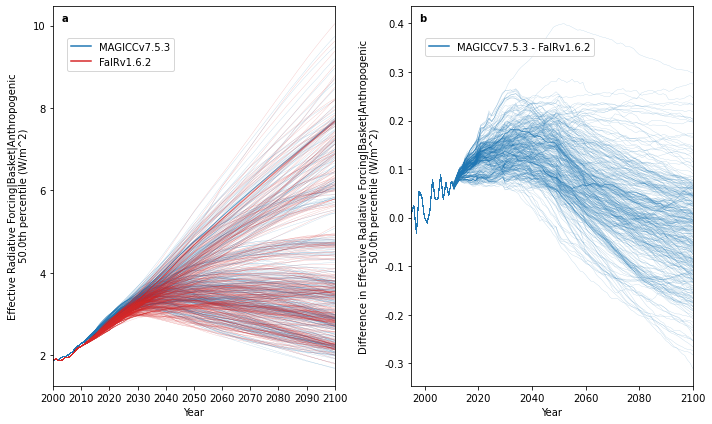

'/data2/ubuntu-znicholls/nicholls-et-al-2022-emulator-changes/src/utils/../../figures/230_Atmospheric-Concentrations-CO2_50_AR6-calibration-SR1-5-processing-MAGICCv7-5-3_AR6-calibration-SR1-5-processing-FaIRv1-6-2.pdf'

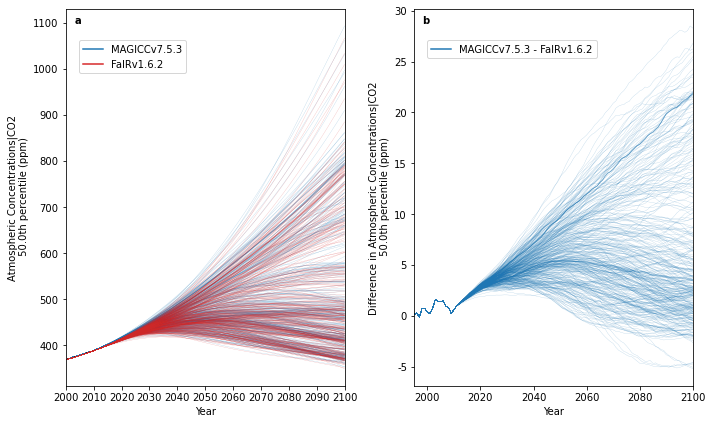

'/data2/ubuntu-znicholls/nicholls-et-al-2022-emulator-changes/src/utils/../../figures/230_Effective-Radiative-Forcing-CO2_50_AR6-calibration-SR1-5-processing-MAGICCv7-5-3_AR6-calibration-SR1-5-processing-FaIRv1-6-2.pdf'

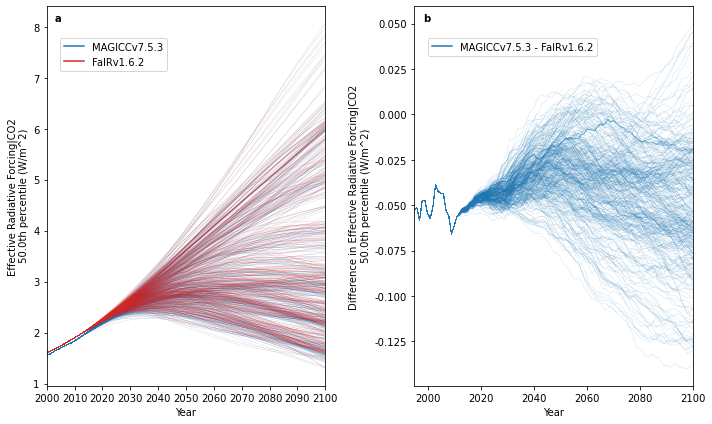

'/data2/ubuntu-znicholls/nicholls-et-al-2022-emulator-changes/src/utils/../../figures/230_Effective-Radiative-Forcing-Aerosols_50_AR6-calibration-SR1-5-processing-MAGICCv7-5-3_AR6-calibration-SR1-5-processing-FaIRv1-6-2.pdf'

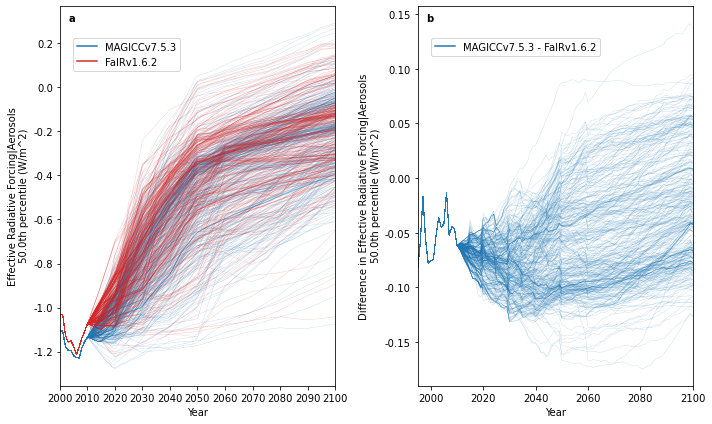

'/data2/ubuntu-znicholls/nicholls-et-al-2022-emulator-changes/src/utils/../../figures/230_Atmospheric-Concentrations-CH4_50_AR6-calibration-SR1-5-processing-MAGICCv7-5-3_AR6-calibration-SR1-5-processing-FaIRv1-6-2.pdf'

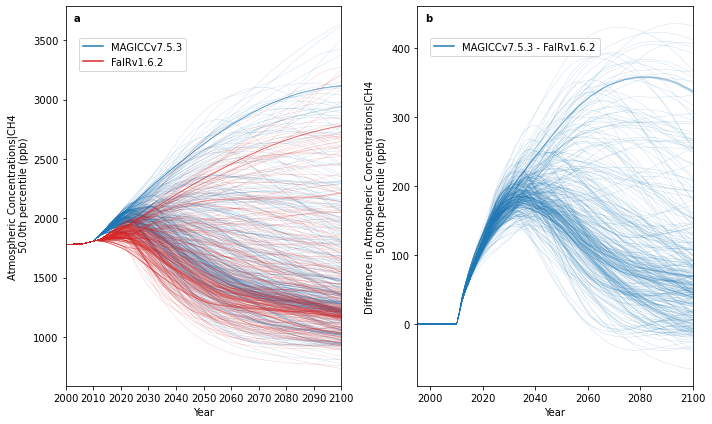

'/data2/ubuntu-znicholls/nicholls-et-al-2022-emulator-changes/src/utils/../../figures/230_Effective-Radiative-Forcing-CH4_50_AR6-calibration-SR1-5-processing-MAGICCv7-5-3_AR6-calibration-SR1-5-processing-FaIRv1-6-2.pdf'

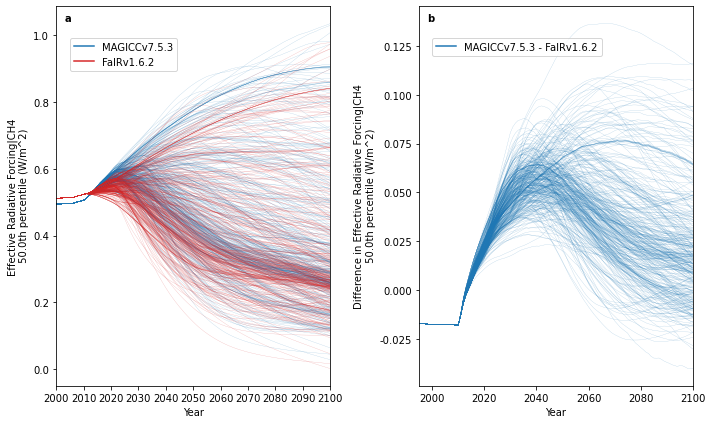

'/data2/ubuntu-znicholls/nicholls-et-al-2022-emulator-changes/src/utils/../../figures/230_Surface-Temperature--GSAT-_50_AR6-calibration-SR1-5-processing-MAGICCv7-5-3_AR6-calibration-SR1-5-processing-FaIRv1-6-2.pdf'

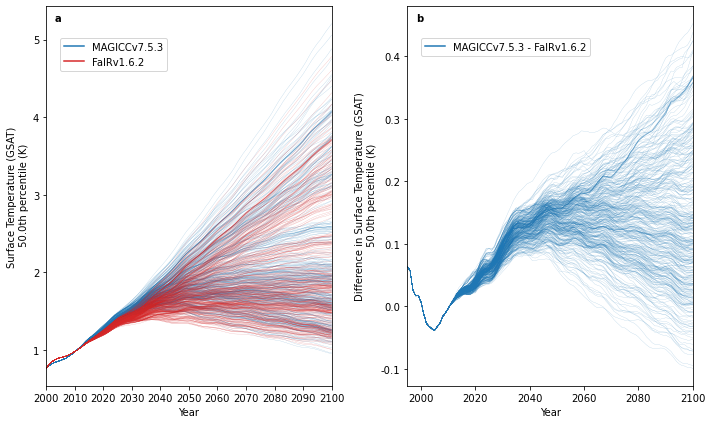

'/data2/ubuntu-znicholls/nicholls-et-al-2022-emulator-changes/src/utils/../../figures/230_Surface-Temperature--GSAT-_67_AR6-calibration-SR1-5-processing-MAGICCv7-5-3_AR6-calibration-SR1-5-processing-FaIRv1-6-2.pdf'

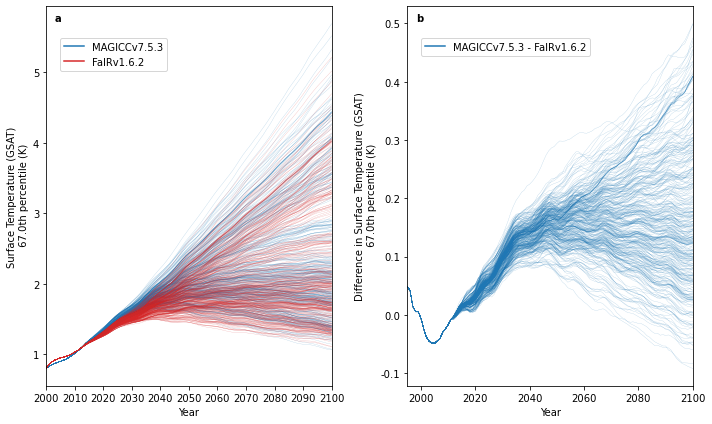

<IPython.core.display.Javascript object>

In [46]:
def get_ms_to_plot(inp, temp_filter=False):
    if temp_filter:
        ms_to_plot = inp.filter(
            variable="Surface Temperature (GSAT)", year=2100, percentile="50.0"
        ).timeseries()
        ms_to_plot = ms_to_plot[ms_to_plot <= 1.5].dropna()
    else:
        ms_to_plot = inp.timeseries()

    ms_to_plot = ms_to_plot.index.get_level_values("model_scenario").tolist()

    return ms_to_plot


temp_filter_overall = False
# temp_filter_overall = True
ms_to_plot = list(
    set(get_ms_to_plot(dat_1, temp_filter=temp_filter_overall)).intersection(
        set(get_ms_to_plot(dat_2, temp_filter=temp_filter_overall))
    )
)
display(ms_to_plot[:5])


hue = "Emulator"
pkwargs = dict(
    units="model_scenario",
    estimator=None,
    legend=True,
    linewidth=0.25,
    alpha=0.4,
)
universal_filters = {"SR1.5 Table 2.4": True}


def get_pdf_dat_vps(dat_1_in, dat_2_in, filters, model_scenarios):
    fhere = {**filters, **universal_filters}
    dat_1_vp = dat_1_in.filter(**fhere)
    try:
        dat_1_vp = dat_1_vp.drop_meta(
            ["Kyoto-GHG|2010 (SAR)", "SR1.5 Table 2.4", "aim_over_sampling"]
        )
    except KeyError:
        pass

    dat_2_vp = dat_2_in.filter(**fhere)
    try:
        dat_2_vp = dat_2_vp.drop_meta(
            ["Kyoto-GHG|2010 (SAR)", "SR1.5 Table 2.4", "aim_over_sampling"]
        )
    except KeyError:
        pass

    dat_1_vp = dat_1_vp.filter(model_scenario=model_scenarios)
    dat_2_vp = dat_2_vp.filter(model_scenario=model_scenarios)

    pdf = dat_1_vp.append(dat_2_vp)

    return pdf, dat_1_vp, dat_2_vp


for v, p in tqdman.tqdm(
    [
        ("Effective Radiative Forcing|Basket|Anthropogenic", 50.0),
        #     ("Effective Radiative Forcing|Basket|Non-CO2 Anthropogenic", 50.0),
        #         ("Effective Radiative Forcing|CO2, CH4 and aerosols", 50.0),
        ("Atmospheric Concentrations|CO2", 50.0),
        ("Effective Radiative Forcing|CO2", 50.0),
        ("Effective Radiative Forcing|Aerosols", 50.0),
        ("Atmospheric Concentrations|CH4", 50.0),
        ("Effective Radiative Forcing|CH4", 50.0),
        #     #     ("Effective Radiative Forcing|Ozone", 50.0),
        #     #     ("Effective Radiative Forcing|Montreal Protocol Halogen Gases", 50.0),
        ("Surface Temperature (GSAT)", 50.0),
        ("Surface Temperature (GSAT)", 67.0),
        #     ("Raw Surface Temperature (GSAT)|Non-CO2", "*"),
    ]
):
    fig, axes = plt.subplots(ncols=2, figsize=(10, 6))

    filters = dict(variable=v, percentile=p)

    pdf, dat_1_vp, dat_2_vp = get_pdf_dat_vps(dat_1, dat_2, filters, ms_to_plot)

    pdf[hue] = pdf["id"].map(utils.plotting.ID_MAP)

    pdf.filter(year=range(2000, 2100 + 1)).lineplot(
        **pkwargs,
        hue=hue,
        palette={
            utils.plotting.ID_MAP[k]: v for k, v in utils.plotting.ID_COLOURS.items()
        },
        ax=axes[0],
    )
    axes[0].set_title(f"{v} {p}")

    if "Raw Surface Temperature (GSAT)|Non-CO2" in v:
        dat_1_vp["percentile"] = "hacked"
        dat_1_vp = dat_1_vp.filter(model_scenario=dat_2_vp["model_scenario"].to_list())
        dat_2_vp["percentile"] = "hacked"

    if (p != "*" or "Prob" in v) or ("Raw Surface Temperature (GSAT)|Non-CO2" in v):
        diff = dat_1_vp.subtract(
            dat_2_vp,
            op_cols={
                "id": f"{utils.plotting.ID_MAP[dat_1_vp.get_unique_meta('id', True)]} - {utils.plotting.ID_MAP[dat_2_vp.get_unique_meta('id', True)]}",
                "climate_model": f"{dat_1_vp.get_unique_meta('climate_model', True)} - {dat_2_vp.get_unique_meta('climate_model', True)}",
            },
        )

        diff["Difference"] = diff["id"]
        diff.lineplot(
            **pkwargs,
            hue="Difference",
            ax=axes[1],
        )

    #     if "Forcing" in v:
    #         axes[1].set_ylim([-0.15, 0.2])

    #     axes[0].grid()
    #     axes[1].grid()

    for i, ax in enumerate(axes):
        ax.set_xlabel("Year")
        ax.annotate(
            string.ascii_lowercase[i],
            xy=(0.03, 0.96),
            xycoords="axes fraction",
            fontweight="bold",
        )
        ax.legend(loc="upper left", bbox_to_anchor=(0.03, 0.93))

    ylabel = f"{axes[0].get_title()}th percentile ({axes[0].get_ylabel()})"
    variable = pdf.get_unique_meta("variable", True)
    ylabel = ylabel.replace(variable, f"{variable}\n")
    axes[0].set_ylabel(ylabel)
    axes[0].set_title("")

    axes[1].set_ylabel(f"Difference in {axes[0].get_ylabel()}")

    out_file = os.path.join(
        utils.FIGURES_DIR,
        f"230_{v.replace('|', '-').replace(' ', '-').replace('(', '-').replace(')', '-')}_{int(p)}_{ID_1.replace('.', '-').replace(' ', '-')}_{ID_2.replace('.', '-').replace(' ', '-')}.pdf",
    )
    display(out_file)
    plt.tight_layout()
    plt.savefig(
        out_file,
        transparent=True,
    )
    plt.show()
#     break

In [45]:
pdf.meta[["model", "scenario"]].drop_duplicates()

model                scenario
0          AIM/CGE 2.0  ADVANCE_2020_1.5C-2100
1          AIM/CGE 2.0      ADVANCE_2020_Med2C
2          AIM/CGE 2.0       ADVANCE_2020_WB2C
3          AIM/CGE 2.0      ADVANCE_2030_Med2C
4          AIM/CGE 2.0  ADVANCE_2030_Price1.5C
..                 ...                     ...
363  WITCH-GLOBIOM 4.4            CD-LINKS_NPi
364  WITCH-GLOBIOM 4.4   CD-LINKS_NPi2020_1000
365  WITCH-GLOBIOM 4.4   CD-LINKS_NPi2020_1600
366  WITCH-GLOBIOM 4.4    CD-LINKS_NPi2020_400
367  WITCH-GLOBIOM 4.4       CD-LINKS_NoPolicy

[368 rows x 2 columns]

<IPython.core.display.Javascript object>